In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, relative_entropy_control_cost_direct
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=300,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)

X = X[y==0,:]
y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

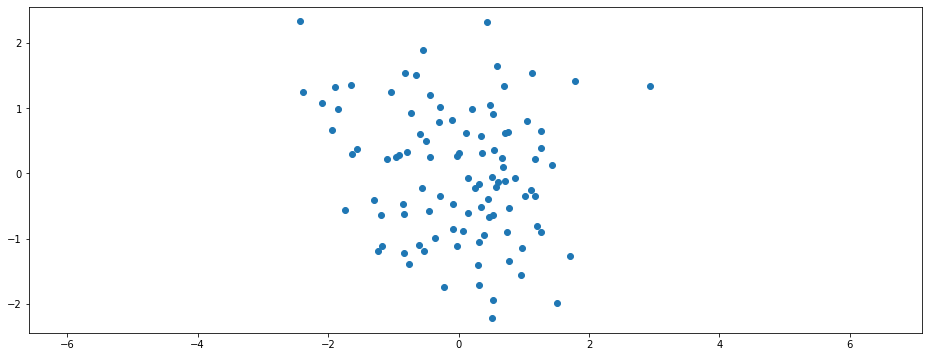

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Variance Matching bug Here

Check out ln_prior there I am tweaking $\sigma_w$ Ive set the log_likelihood to be 0 this way our algorithm should be trying to have as target the prior . For some reason the neural net is completely unable to match the variance I am specifying I have gone from very low to very high and the method is unable to do anhything to fit the target variance. For a sufficiently small $\Delta t$ we should be able to do this, standard VI is able to do this, so theres some sort of bug / issue here. 

In [5]:
# TODO: Why is changing σ_w doing nothing ??
def ln_prior(Θ, σ_w=20.1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * ((Θ-10)**2).sum(axis=1) / σ_w

In [6]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [7]:
relative_entropy_control_cost_direct(sde, Θ_0, ln_prior, γ=1.0, device=device)

tensor(4.2348, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
γ = 1.0
Δt=0.005
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =0.1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost_direct(
                    sde, Θ_0.float(),
                    ln_prior, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost_direct(
                sde, Θ_0,
                ln_prior, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

200


  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
losses

[4.561178207397461,
 4.646542072296143,
 4.079276084899902,
 3.7716822624206543,
 4.183079719543457,
 4.2075581550598145,
 4.375487327575684,
 3.6762804985046387,
 4.297973155975342,
 4.0202131271362305,
 4.189715385437012,
 3.9465157985687256,
 3.962609052658081,
 4.066720008850098,
 4.1656718254089355,
 3.4938511848449707,
 4.05947732925415,
 3.9598071575164795,
 3.9728755950927734,
 3.9027295112609863,
 3.7322285175323486,
 3.6306910514831543,
 3.8515725135803223,
 3.835222005844116,
 3.865710973739624,
 4.0101118087768555,
 3.9136769771575928,
 3.940493106842041,
 4.122621536254883,
 3.9109716415405273,
 4.18317985534668,
 4.047577857971191,
 4.219486236572266,
 4.099632263183594,
 4.027738571166992,
 4.074793338775635,
 3.893461227416992,
 3.8323607444763184,
 4.13564920425415,
 3.8764708042144775,
 4.142397880554199,
 4.173806190490723,
 4.0851006507873535,
 3.984489679336548,
 4.169976234436035,
 4.072145462036133,
 3.7696423530578613,
 3.9680657386779785,
 4.125401020050049,
 4

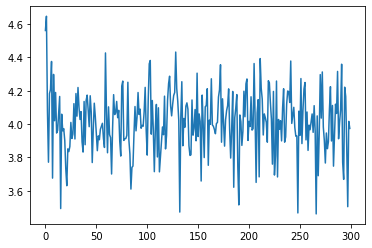

In [10]:
plt.plot(losses[:])

In [11]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([200, 50, 2])

In [12]:
torch.eye(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [13]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [14]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 1.,  0.,  1.,  3., 15.,  9.,  8.,  5.,  6.,  2.]),
 array([-3.3900237 , -2.8065565 , -2.2230892 , -1.639622  , -1.0561547 ,
        -0.47268748,  0.11077976,  0.694247  ,  1.2777143 ,  1.8611815 ,
         2.4446487 ], dtype=float32),
 <a list of 10 Patch objects>)

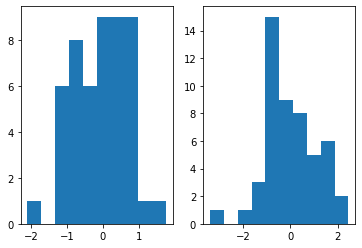

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

In [16]:

# Manually doing 2 steps of euler 
Θ_2 = sde.f(0, 
        sde.f(0, Θ_0) * Δt + torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)
    ) * Δt +  torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)

> c:\users\vargf\onedrive\documents\projects\controlledfollmerdrift\cfollmer\sampler_utils.py(49)f()
     47         except:
     48             import pdb; pdb.set_trace()
---> 49         return self.μ(y)   # shape (batch_size, state_size)
     50 
     51     # Diffusion

ipdb> y.shape
torch.Size([50, 2])
ipdb> t_.shape
*** NameError: name 't_' is not defined
ipdb> t.shape
*** AttributeError: 'int' object has no attribute 'shape'
ipdb> ll
     41     def f(self, t, y):
     42         try:
     43             d = y.shape[0] if len(y.shape) == 2 else y.shape[1]
     44             t_ = t.to(self.device) * torch.ones(d,1).to(self.device)
     45             t_ = t_ if len(y.shape) == 2 else t_.T[...,None]
     46             y = torch.cat((y, t_), dim=-1)
     47         except:
     48             import pdb; pdb.set_trace()
---> 49         return self.μ(y)   # shape (batch_size, state_size)
     50 

ipdb> q


BdbQuit: 

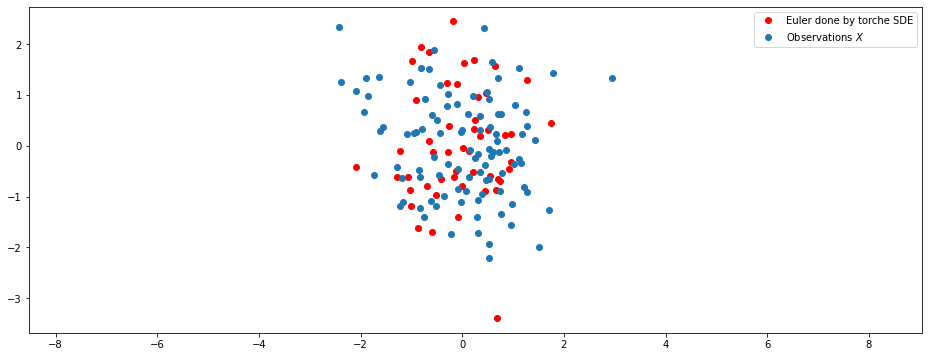

In [18]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

# Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');